C:\Users\user\AppData\Local\Temp\ipykernel_30468\2008415539.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diabetes'] = (df['Diabetes_Diagnosis'] == 1).astype(int)



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       434
           1       0.00      0.00      0.00         2

    accuracy                           1.00       436
   macro avg       0.50      0.50      0.50       436
weighted avg       0.99      1.00      0.99       436



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


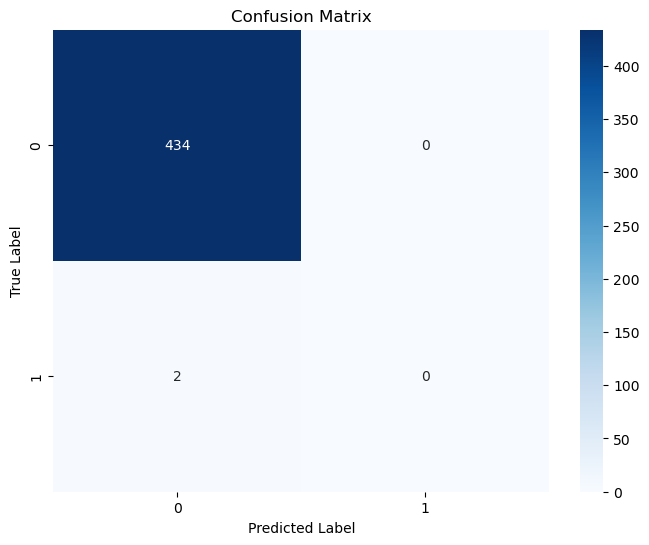

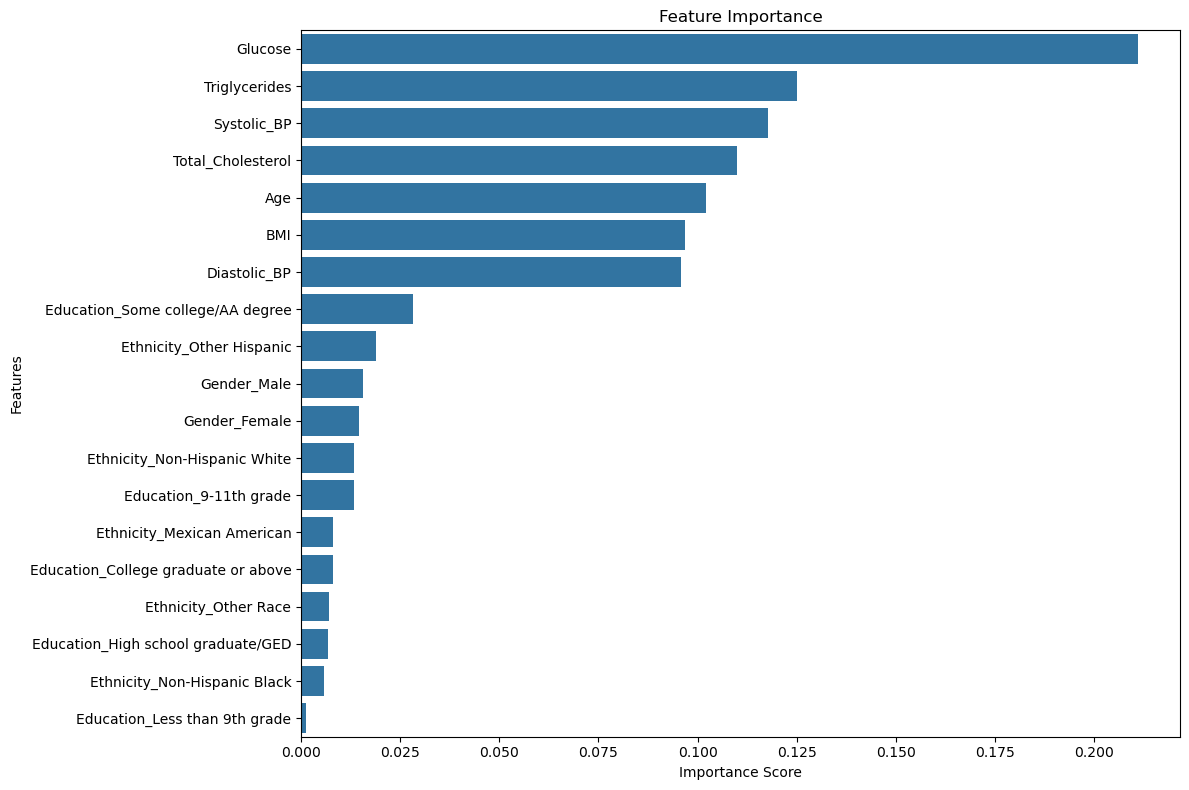


Feature names for making predictions:
['Age', 'BMI', 'Systolic_BP', 'Diastolic_BP', 'Total_Cholesterol', 'Triglycerides', 'Glucose', 'Gender_Female', 'Gender_Male', 'Education_9-11th grade', 'Education_College graduate or above', 'Education_High school graduate/GED', 'Education_Less than 9th grade', 'Education_Some college/AA degree', 'Ethnicity_Mexican American', 'Ethnicity_Non-Hispanic Black', 'Ethnicity_Non-Hispanic White', 'Ethnicity_Other Hispanic', 'Ethnicity_Other Race']


In [34]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
demographic = pd.read_csv('Dataset/demographic.csv')
examination = pd.read_csv('Dataset/examination.csv')
labs = pd.read_csv('Dataset/labs.csv')
questionnaire = pd.read_csv('Dataset/questionnaire.csv')

# Select relevant features from each dataset
# Demographic features
demo_features = demographic[['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC2']]
# Rename demographic columns
demo_features.columns = ['ID', 'Gender', 'Age', 'Ethnicity', 'Education']

# Examination features
exam_features = examination[['SEQN', 'BMXBMI', 'BPXSY1', 'BPXDI1']]
# Rename examination columns
exam_features.columns = ['ID', 'BMI', 'Systolic_BP', 'Diastolic_BP'] # Diastolic = 張開 ; Systolic_BP = 收縮

# Lab features
#lab_features = labs[['SEQN', 'LBXGLU', 'LBXTC', 'LBXTR']]
lab_features = labs[['SEQN', 'LBXTC', 'LBXTR', 'LBXGLT']]
# Rename lab columns
#lab_features.columns = ['SEQN', 'Glucose', 'Total_Cholesterol', 'Triglycerides']
lab_features.columns = ['ID', 'Total_Cholesterol', 'Triglycerides', 'Glucose']

# Questionnaire features
quest_features = questionnaire[['SEQN', 'DIQ010']]
quest_features.columns = ['ID', 'Diabetes_Diagnosis']

# Merge all datasets
merged_data = demo_features.merge(exam_features, on='ID', how='left')\
    .merge(lab_features, on='ID', how='left')\
    .merge(quest_features, on='ID', how='left')

# Create category mappings
gender_map = {1: 'Male', 2: 'Female'}
education_map = {1: 'Less than 9th grade', 
                2: '9-11th grade', 
                3: 'High school graduate/GED',
                4: 'Some college/AA degree',
                5: 'College graduate or above'}
ethnicity_map = {1: 'Mexican American',
                2: 'Other Hispanic',
                3: 'Non-Hispanic White',
                4: 'Non-Hispanic Black',
                5: 'Other Race'}

# Apply mappings
merged_data['Gender'] = merged_data['Gender'].map(gender_map)
merged_data['Education'] = merged_data['Education'].map(education_map)
merged_data['Ethnicity'] = merged_data['Ethnicity'].map(ethnicity_map)

# Convert categorical variables to dummy variables
merged_data = pd.get_dummies(merged_data, columns=['Gender', 'Education', 'Ethnicity'])

# Clean and preprocess data
def preprocess_data(df):
    # Handle missing values
    df = df.dropna()
    
    # Create target variable (1 for diabetes, 0 for no diabetes)
    df['diabetes'] = (df['Diabetes_Diagnosis'] == 1).astype(int)
    
    # Drop unnecessary columns
    df = df.drop(['ID', 'Diabetes_Diagnosis'], axis=1)
    
    return df

# Preprocess the merged dataset
processed_data = preprocess_data(merged_data)

# Split features and target
X = processed_data.drop('diabetes', axis=1)
y = processed_data['diabetes']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Print model evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance plot
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Function to predict diabetes risk for new patients
def predict_diabetes_risk(patient_data):
    # Scale the input data
    scaled_data = scaler.transform(patient_data)
    # Get prediction probability
    risk_prob = rf_model.predict_proba(scaled_data)[:, 1]
    return risk_prob

# Print the feature names for reference when making predictions
print("\nFeature names for making predictions:")
print(X.columns.tolist())

In [16]:
processed_data

,Age,BMI,Systolic_BP,Diastolic_BP,Total_Cholesterol,Triglycerides,Gender_Female,Gender_Male,Education_9-11th grade,Education_College graduate or above,Education_High school graduate/GED,Education_Less than 9th grade,Education_Some college/AA degree,Ethnicity_Mexican American,Ethnicity_Non-Hispanic Black,Ethnicity_Non-Hispanic White,Ethnicity_Other Hispanic,Ethnicity_Other Race,diabetes
2,72,28.9,140.0,90.0,126.0,51.0,False,True,False,False,False,False,True,False,False,True,False,False,1
4,73,19.7,136.0,86.0,201.0,75.0,True,False,False,True,False,False,False,False,False,True,False,False,0
7,61,35.7,118.0,80.0,168.0,64.0,True,False,False,True,False,False,False,False,False,True,False,False,0
11,26,20.3,106.0,60.0,168.0,24.0,True,False,False,True,False,False,False,False,False,True,False,False,0
17,33,22.8,122.0,56.0,131.0,14.0,True,False,False,True,False,False,False,False,False,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10156,34,23.7,118.0,66.0,180.0,194.0,False,True,False,False,False,False,True,False,False,False,False,True,0
10157,19,28.1,112.0,64.0,187.0,141.0,True,False,False,False,False,False,False,False,False,True,False,False,0
10159,17,24.1,104.0,60.0,143.0,101.0,False,True,False,False,False,False,False,False,False,True,False,False,0
10161,60,27.4,114.0,72.0,221.0,71.0,True,False,False,False,True,False,False,False,True,False,False,False,0
